In [2]:
from econml.iv.nnet import DeepIV
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2023-01-25 11:02:05.826137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


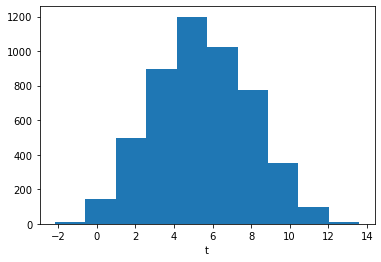

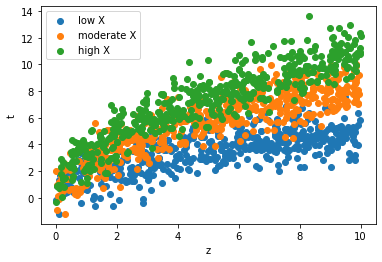

In [3]:
n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n,))
x = np.random.uniform(low=0.0, high=10.0, size=(n,))
z = np.random.uniform(low=0.0, high=10.0, size=(n,))

# Initialize treatment variable
t = np.sqrt((x+2) * z) + e

# Show the marginal distribution of t
plt.hist(t)
plt.xlabel("t")
plt.show()

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.xlabel("z")
plt.ylabel("t")
plt.show()

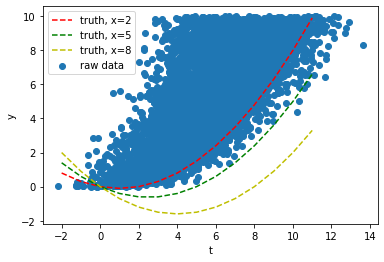

In [4]:
# Outcome equation 
y = t*t / 10 - x*t / 10 + e

# The endogeneity problem is clear, the latent error enters both treatment and outcome equally
plt.scatter(t,z, label ='raw data')
tticks = np.arange(-2,12)
yticks2 = tticks*tticks/10 - 0.2 * tticks
yticks5 = tticks*tticks/10 - 0.5 * tticks
yticks8 = tticks*tticks/10 - 0.8 * tticks
plt.plot(tticks,yticks2, 'r--', label = 'truth, x=2')
plt.plot(tticks,yticks5, 'g--', label = 'truth, x=5')
plt.plot(tticks,yticks8, 'y--', label = 'truth, x=8')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [5]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

In [6]:
keras_fit_options = { "epochs": 30,
                      "validation_split": 0.1,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t,x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response (to make loss estimate unbiased)
                   optimizer='adam', # Keras optimizer to use for training - see https://keras.io/optimizers/ 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [7]:
deepIvEst.fit(Y=y,T=t,X=x,Z=z)


Epoch 1/30
141/141 [==============================] - 1s 3ms/step - loss: 1.8520 - val_loss: 0.8673
Epoch 2/30
141/141 [==============================] - 0s 1ms/step - loss: 1.0828 - val_loss: 0.8417
Epoch 3/30
141/141 [==============================] - 0s 2ms/step - loss: 0.9405 - val_loss: 0.6848
Epoch 4/30
141/141 [==============================] - 0s 1ms/step - loss: 0.8958 - val_loss: 0.7847
Epoch 5/30
141/141 [==============================] - 0s 2ms/step - loss: 0.8576 - val_loss: 0.6261
Epoch 6/30
141/141 [==============================] - 0s 2ms/step - loss: 0.8339 - val_loss: 0.6375
Epoch 7/30
141/141 [==============================] - 0s 2ms/step - loss: 0.7867 - val_loss: 0.6339
Epoch 1/30
141/141 [==============================] - 2s 5ms/step - loss: 4.3036 - val_loss: 3.5034
Epoch 2/30
141/141 [==============================] - 0s 3ms/step - loss: 4.5427 - val_loss: 3.8516
Epoch 3/30
141/141 [==============================] - 0s 2ms/step - loss: 4.6621 - val_loss: 3.6223


4/4 [==============================] - 0s 1ms/step


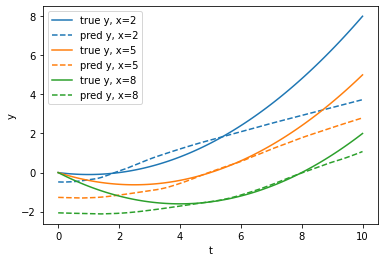

In [8]:

n_test = 500
for i, x in enumerate([2, 5, 8]):
    t = np.linspace(0,10,num = 100)
    y_true = t*t / 10 - x*t/10
    y_pred = deepIvEst.predict(t, np.full_like(t, x))
    plt.plot(t, y_true, label='true y, x={0}'.format(x),color='C'+str(i))
    plt.plot(t, y_pred, label='pred y, x={0}'.format(x),color='C'+str(i),ls='--')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()